In [1]:
import pandas as pd

In [2]:
rutas = pd.read_csv('../datos/rutas_turisticas.csv')

In [3]:
transporte = pd.read_csv('../datos/uso_transporte.csv')

In [4]:
ocupacion = pd.read_csv('../datos/ocupacion_hotelera.csv')

In [5]:
opiniones = pd.read_csv('../datos/opiniones_turisticas.csv')

In [6]:
sostenibilidad = pd.read_csv('../datos/datos_sostenibilidad.csv')

### Dataset con la puntuación media de los 166 servicios de GreenLake.

In [13]:
# Agrupar opiniones por nombre_servicio y calcular la media de las puntuaciones
conteo_servicios = opiniones['nombre_servicio'].value_counts().to_dict()
opiniones_agrupadas = opiniones.groupby(['nombre_servicio', 'tipo_servicio']).agg({'puntuacion': 'mean'}).reset_index()
opiniones_agrupadas['Num_opiniones'] = opiniones['nombre_servicio'].map(conteo_servicios)

# Renombrar la columna de puntuacion a media_puntuacion
opiniones_agrupadas.rename(columns={'puntuacion': 'media_puntuacion'}, inplace=True)

opiniones_agrupadas['descripcion_servicio'] = opiniones_agrupadas.apply(
    lambda row: row['tipo_servicio'] if row['tipo_servicio'] in ['Hotel', 'Ruta'] else row['nombre_servicio'].split()[-1],
    axis=1
)
opiniones_agrupadas['descripcion_servicio'] = opiniones_agrupadas['descripcion_servicio'].replace('Guiado', 'Tour Guiado')

## Ocupación hoteles

/var/folders/k2/p_2k6jgx3836yjfwy9gj_mgc0000gn/T/ipykernel_27125/907585400.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prolliant_data['fecha'] = pd.to_datetime(prolliant_data['fecha'])


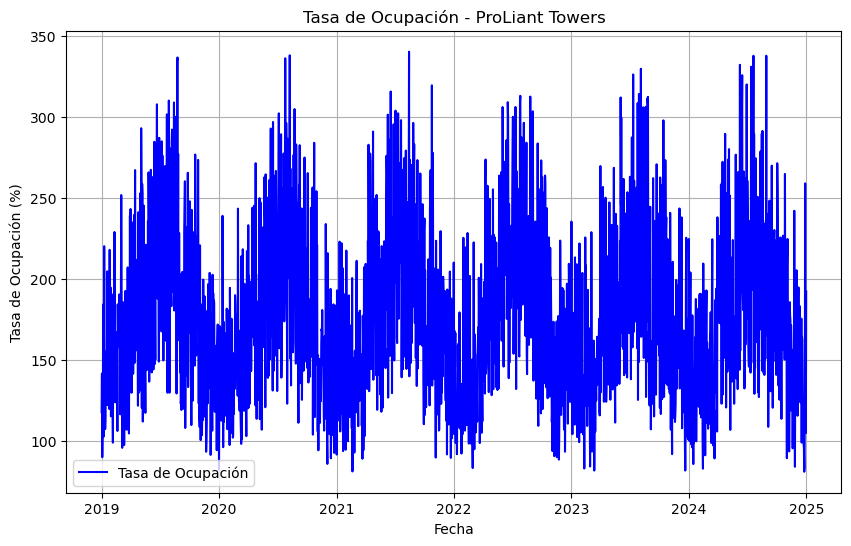

In [7]:
import matplotlib.pyplot as plt

# Filtrar los datos del hotel "ProLiant Towers"
prolliant_data = ocupacion[ocupacion['hotel_nombre'] == 'Aruba Luxury Lodge']

# Convertir la columna 'fecha' a formato datetime para una mejor representación
prolliant_data['fecha'] = pd.to_datetime(prolliant_data['fecha'])

# Representar la tasa de ocupación en función de la fecha
plt.figure(figsize=(10, 6))
plt.plot(prolliant_data['fecha'], prolliant_data['precio_promedio_noche'], label='Tasa de Ocupación', color='blue')
plt.title('Tasa de Ocupación - ProLiant Towers')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Ocupación (%)')
plt.legend()
plt.grid()
plt.show()

In [8]:
num_hoteles_distintos = ocupacion['hotel_nombre'].nunique()
print(f"Número de hoteles distintos: {num_hoteles_distintos}")

Número de hoteles distintos: 25


In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Asegurarse de que la columna 'fecha' esté en formato datetime
ocupacion['fecha'] = pd.to_datetime(ocupacion['fecha'])
# Crear las nuevas columnas
ocupacion['dia_semana'] = ocupacion['fecha'].dt.weekday  # Día de la semana (0=Lunes, 6=Domingo)
ocupacion['mes'] = ocupacion['fecha'].dt.month  # Mes
ocupacion['semana'] = ocupacion['fecha'].dt.isocalendar().week  # Semana del año

# Crear un DataFrame para almacenar las predicciones
predicciones = pd.DataFrame()

# Iterar sobre cada hotel
#for hotel in ocupacion['hotel_nombre'].unique():
hotel = 'Aruba Luxury Lodge'
if True:
    # Filtrar los datos del hotel
    hotel_data = ocupacion[ocupacion['hotel_nombre'] == hotel]
    
    # Agrupar por fecha y calcular la ocupación promedio diaria
    hotel_data = hotel_data.groupby('fecha')['tasa_ocupacion'].mean()
    
    # Crear un índice de fecha completo para manejar fechas faltantes
    hotel_data = hotel_data.asfreq('D').fillna(method='ffill')
    
    # Descomponer la serie temporal para capturar el patrón estacional
    decomposition = seasonal_decompose(hotel_data, model='additive', period=365)
    estacionalidad = decomposition.seasonal
    
    # Predecir la ocupación para el año 2026
    fechas_prediccion = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')
    prediccion = estacionalidad[:len(fechas_prediccion)].values + hotel_data.mean()
    
    # Almacenar las predicciones
    predicciones = pd.concat([predicciones, pd.DataFrame({
        'hotel_nombre': hotel,
        'fecha': fechas_prediccion,
        'tasa_ocupacion_predicha': prediccion
    })])

# Mostrar las primeras filas de las predicciones
print(predicciones.head())

         hotel_nombre      fecha  tasa_ocupacion_predicha
0  Aruba Luxury Lodge 2025-01-01                43.298420
1  Aruba Luxury Lodge 2025-01-02                51.108283
2  Aruba Luxury Lodge 2025-01-03                52.108283
3  Aruba Luxury Lodge 2025-01-04                44.711571
4  Aruba Luxury Lodge 2025-01-05                41.315407


/var/folders/k2/p_2k6jgx3836yjfwy9gj_mgc0000gn/T/ipykernel_27125/2174949195.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hotel_data = hotel_data.asfreq('D').fillna(method='ffill')


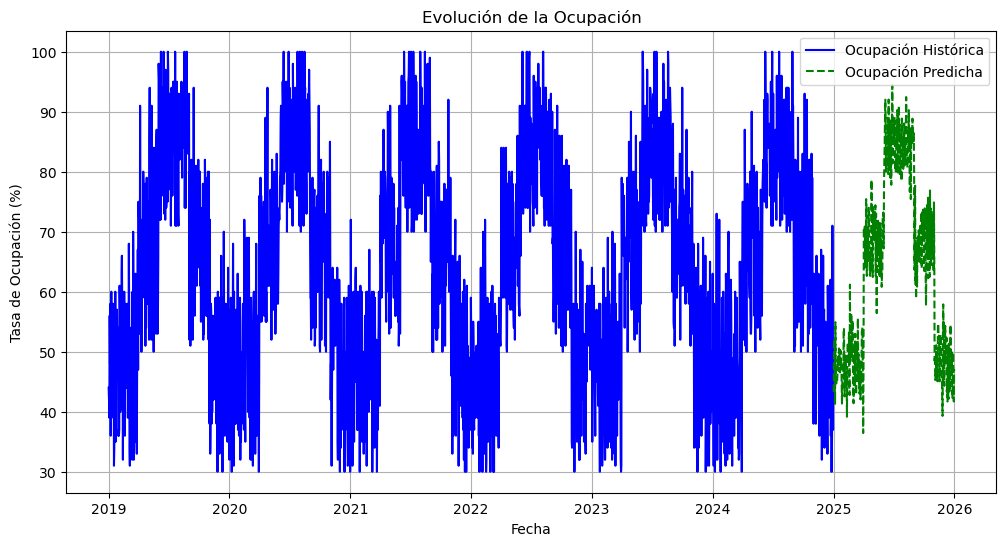

In [16]:
# Concatenar los datos históricos de ocupación con las predicciones
ocupacion_historica = prolliant_data[['fecha', 'tasa_ocupacion']].rename(columns={'tasa_ocupacion': 'tasa_ocupacion_historica'})
ocupacion_predicha = predicciones[['fecha', 'tasa_ocupacion_predicha']]

# Unir ambos DataFrames
ocupacion_completa = pd.concat([ocupacion_historica.set_index('fecha'), ocupacion_predicha.set_index('fecha')]).reset_index()

# Graficar la evolución de la ocupación
plt.figure(figsize=(12, 6))
plt.plot(ocupacion_completa['fecha'], ocupacion_completa['tasa_ocupacion_historica'], label='Ocupación Histórica', color='blue')
plt.plot(ocupacion_completa['fecha'], ocupacion_completa['tasa_ocupacion_predicha'], label='Ocupación Predicha', color='green', linestyle='--')
plt.title('Evolución de la Ocupación')
plt.xlabel('Fecha')
plt.ylabel('Tasa de Ocupación (%)')
plt.legend()
plt.grid()
plt.show()